In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score,recall_score
from sklearn.model_selection import GridSearchCV

In [4]:
!mkdir -p ~/.kaggle  # Create the directory if not exists
!mv kaggle.json ~/.kaggle/  # Move the API key to the correct location
!chmod 600 ~/.kaggle/kaggle.json  # Secure the file

# Download the dataset
!kaggle datasets download -d datasetengineer/logistics-and-supply-chain-dataset --unzip

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/datasetengineer/logistics-and-supply-chain-dataset
License(s): CC0-1.0
 87% 6.00M/6.89M [00:00<00:00, 59.8MB/s]
100% 6.89M/6.89M [00:00<00:00, 64.1MB/s]


In [5]:
df = pd.read_csv('dynamic_supply_chain_logistics_dataset.csv')
df.drop(columns=['timestamp', 'vehicle_gps_latitude', 'vehicle_gps_longitude'], inplace=True)
df.head()

,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,...,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,0.359066,4.289160,456.503853,...,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682
1,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,0.230660,7.018373,640.408205,...,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281
2,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,0.027210,9.605064,155.749314,...,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594
3,8.219558,3.095064,0.045257,0.573283,0.530186,0.008525,0.811885,0.616619,8.899616,104.317961,...,-0.151276,0.877576,0.548952,4.674035,0.362885,0.905444,0.993320,0.025977,High Risk,9.304897
4,5.000075,3.216077,8.004851,914.925067,3.620890,0.020083,0.053659,0.952385,0.061760,977.222528,...,2.429448,0.262081,8.861443,3.445429,0.016957,0.258702,0.912433,0.991122,High Risk,7.752484


In [6]:
# Look if there are any duplicate rows in the dataset
df.loc[df.duplicated()]

,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,...,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation


In [7]:
# Check for null values
df.isna().sum()

,0
fuel_consumption_rate,0
eta_variation_hours,0
traffic_congestion_level,0
warehouse_inventory_level,0
loading_unloading_time,0
handling_equipment_availability,0
order_fulfillment_status,0
weather_condition_severity,0
port_congestion_level,0
shipping_costs,0


In [8]:
numerical_list = [x for x in df.columns if df[x].dtype in ('int64','float64')]
print(numerical_list)

['fuel_consumption_rate', 'eta_variation_hours', 'traffic_congestion_level', 'warehouse_inventory_level', 'loading_unloading_time', 'handling_equipment_availability', 'order_fulfillment_status', 'weather_condition_severity', 'port_congestion_level', 'shipping_costs', 'supplier_reliability_score', 'lead_time_days', 'historical_demand', 'iot_temperature', 'cargo_condition_status', 'route_risk_level', 'customs_clearance_time', 'driver_behavior_score', 'fatigue_monitoring_score', 'disruption_likelihood_score', 'delay_probability', 'delivery_time_deviation']


In [9]:
#Removal of outlier:

df1 = df.copy()

for i in numerical_list:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
# display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))
df = df1.copy()
df.head()


Inference:
Before removal of outliers, The dataset had 32065 samples.
After removal of outliers, The dataset now has 25245 samples.


,fuel_consumption_rate,eta_variation_hours,traffic_congestion_level,warehouse_inventory_level,loading_unloading_time,handling_equipment_availability,order_fulfillment_status,weather_condition_severity,port_congestion_level,shipping_costs,...,iot_temperature,cargo_condition_status,route_risk_level,customs_clearance_time,driver_behavior_score,fatigue_monitoring_score,disruption_likelihood_score,delay_probability,risk_classification,delivery_time_deviation
0,5.136512,4.998009,5.927586,985.716862,4.951392,0.481294,0.761166,0.359066,4.289160,456.503853,...,0.574400,0.777263,1.182116,0.502006,0.033843,0.978599,0.506152,0.885291,Moderate Risk,9.110682
1,5.101512,0.984929,1.591992,396.700206,1.030379,0.620780,0.196594,0.230660,7.018373,640.408205,...,-9.753493,0.091839,9.611988,0.966774,0.201725,0.918586,0.980784,0.544178,High Risk,8.175281
2,5.090803,4.972665,8.787765,832.408935,4.220229,0.810933,0.152742,0.027210,9.605064,155.749314,...,-6.491034,0.253529,6.570431,0.945627,0.264045,0.394215,0.998633,0.803322,High Risk,1.283594
3,8.219558,3.095064,0.045257,0.573283,0.530186,0.008525,0.811885,0.616619,8.899616,104.317961,...,-0.151276,0.877576,0.548952,4.674035,0.362885,0.905444,0.993320,0.025977,High Risk,9.304897
4,5.000075,3.216077,8.004851,914.925067,3.620890,0.020083,0.053659,0.952385,0.061760,977.222528,...,2.429448,0.262081,8.861443,3.445429,0.016957,0.258702,0.912433,0.991122,High Risk,7.752484


In [10]:
# Label encoding

label_encoder = LabelEncoder()
df['risk_classification'] = label_encoder.fit_transform(df['risk_classification'])

In [11]:
# target class are highly imbalanced
df['risk_classification'].value_counts()

,count
risk_classification,
0,20451
2,4277
1,517


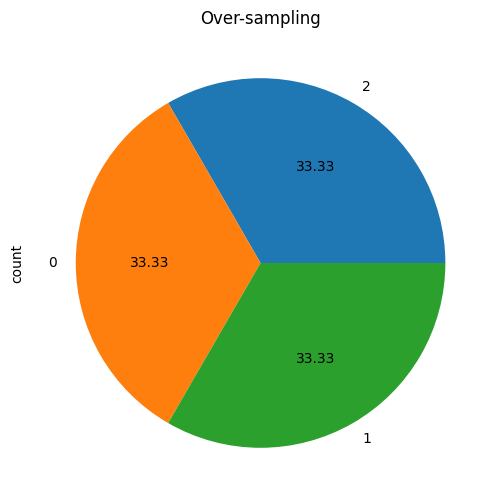

In [12]:
# solve imbalnce class

#Random Oversampling
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(sampling_strategy="not majority") # String
# X = df.drop(['risk_classification'], axis=1)
# Y = df['risk_classification']
# X, Y = ros.fit_resample(X, Y)

# ------------------------------------------------------------

# Apply SMOTE (Synthetic Minority Over-sampling)
from imblearn.over_sampling import SMOTE
X = df.drop(columns=["risk_classification"])  # Features
Y = df["risk_classification"]  # Target
smote = SMOTE(sampling_strategy="auto", random_state=42)
X, Y = smote.fit_resample(X, Y)

ax = Y.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

In [13]:
# after solve imbalnce class
Y.value_counts()

,count
risk_classification,
2,20451
0,20451
1,20451


In [16]:
# Split the data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.25,random_state = 42)

#  Select Features Using Information Gain For Classification In ML

from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([0.0354594 , 0.03286099, 0.0264211 , 0.02363777, 0.02880101,
       0.02968168, 0.03862609, 0.02840366, 0.03517182, 0.02091676,
       0.03120255, 0.03488875, 0.04906425, 0.03266487, 0.03747905,
       0.02842418, 0.0259958 , 0.03713994, 0.03534024, 1.09861532,
       0.0325446 , 0.03816075])

In [17]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

,0
disruption_likelihood_score,1.098615
historical_demand,0.049064
order_fulfillment_status,0.038626
delivery_time_deviation,0.038161
cargo_condition_status,0.037479
driver_behavior_score,0.037140
fuel_consumption_rate,0.035459
fatigue_monitoring_score,0.035340
port_congestion_level,0.035172
lead_time_days,0.034889


<Axes: >

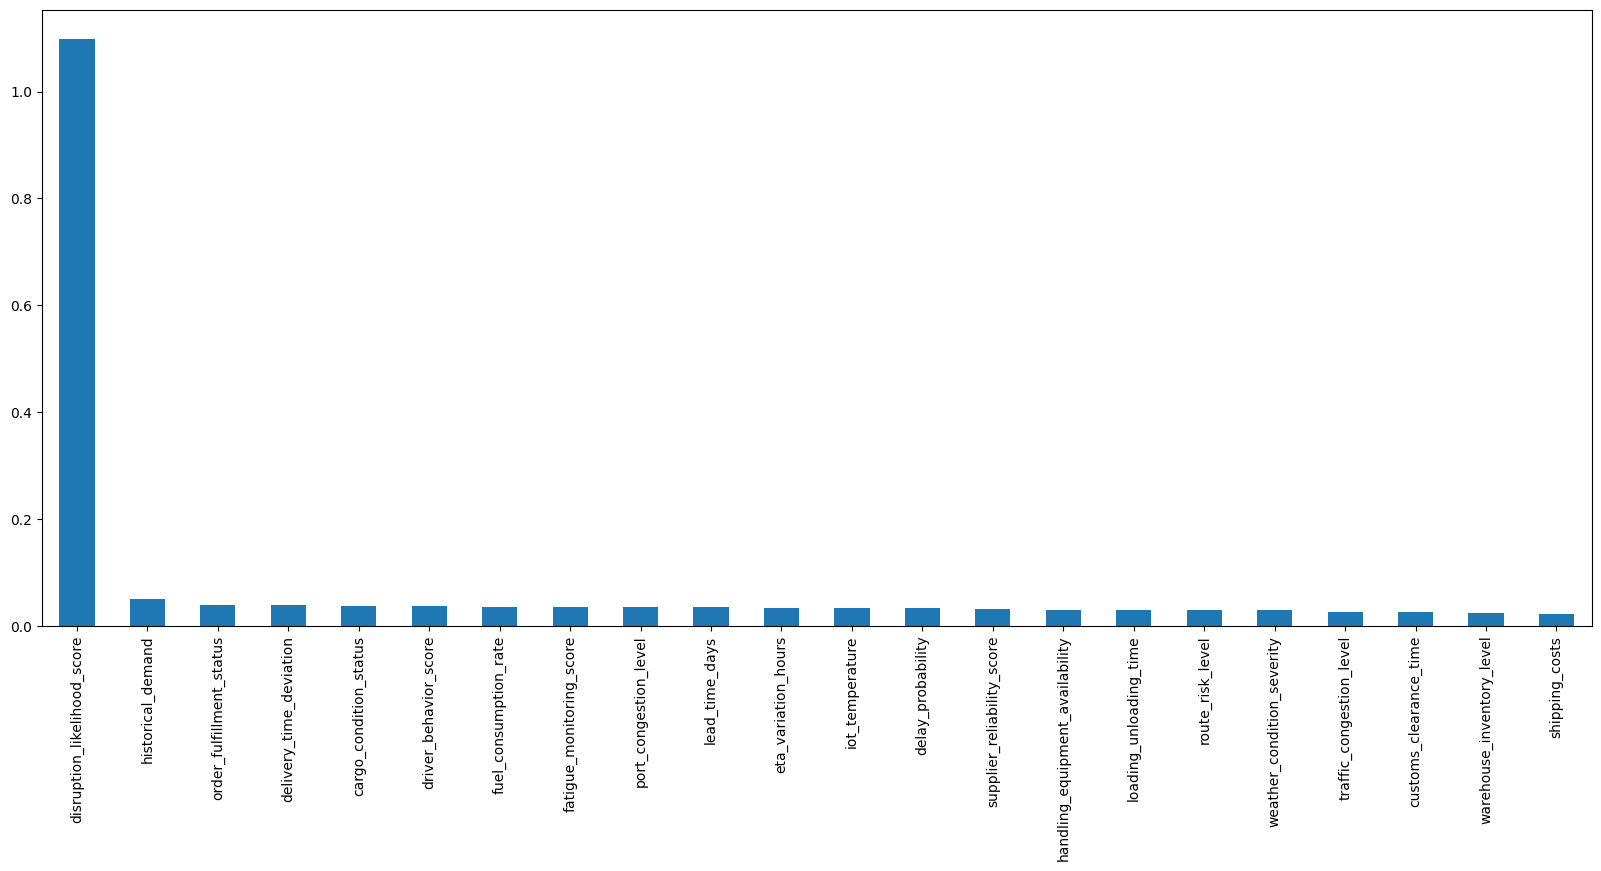

In [18]:
#let's plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [19]:
from sklearn.feature_selection import SelectKBest

#No we Will select the  top 5 important features
sel_five_cols = SelectKBest(mutual_info_classif, k=5)
sel_five_cols.fit(X_train, y_train)
selected_feature = X_train.columns[sel_five_cols.get_support()]
print(f"Top 5 Feature: {selected_feature}")

Top 5 Feature: Index(['order_fulfillment_status', 'historical_demand',
       'cargo_condition_status', 'disruption_likelihood_score',
       'delivery_time_deviation'],
      dtype='object')


In [20]:
X_train = X_train[selected_feature]
X_test = X_test[selected_feature]

X_train

,order_fulfillment_status,historical_demand,cargo_condition_status,disruption_likelihood_score,delivery_time_deviation
24481,0.882777,7205.246476,0.035134,1.000000,2.348545
58434,0.247370,7995.285807,0.594477,0.562096,8.768822
22492,0.756477,9932.483769,0.477842,0.776728,9.828261
39689,0.318124,9957.979009,0.194927,0.268893,7.516259
2888,0.916517,2104.904816,0.722561,0.999998,1.697481
...,...,...,...,...,...
54343,0.461909,9966.174332,0.076690,0.487871,6.648762
38158,0.930660,4601.759031,0.754161,0.292436,-0.352302
860,0.632656,8251.035573,0.217659,0.953890,3.389473
15795,0.853349,9967.005582,0.937680,0.999965,9.107156


In [21]:
# Transform data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
print(X_train_scaled)
X_test_scaled = scaler.transform(X_test)

[[0.88277692 0.71770158 0.03513418 0.9999999  0.36237853]
 [0.24736903 0.79750356 0.59447666 0.42515965 0.89740183]
 [0.7564762  0.99318018 0.47784152 0.70690859 0.98568843]
 ...
 [0.6326551  0.82333687 0.21765886 0.9394711  0.4491226 ]
 [0.85334865 0.99666723 0.93767998 0.99995409 0.9255963 ]
 [0.6650766  0.73330631 0.01289791 0.14487667 0.67038991]]


In [ ]:
# code your own model from now on ....

In [23]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Use long for classification
y_val_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [32]:
y_train_tensor

tensor([0, 2, 0,  ..., 0, 0, 2])

In [48]:
X_train_tensor

tensor([[0.8828, 0.7177, 0.0351, 1.0000, 0.3624],
        [0.2474, 0.7975, 0.5945, 0.4252, 0.8974],
        [0.7565, 0.9932, 0.4778, 0.7069, 0.9857],
        ...,
        [0.6327, 0.8233, 0.2177, 0.9395, 0.4491],
        [0.8533, 0.9967, 0.9377, 1.0000, 0.9256],
        [0.6651, 0.7333, 0.0129, 0.1449, 0.6704]])

In [50]:
val_randn = np.random.randn(5, 3)
print(val_randn)

[[ 0.34389816  1.40680843  2.11631952]
 [ 0.68437091 -0.35334348  0.660203  ]
 [ 0.02337233 -0.1154178   1.24893977]
 [-0.23395596  0.35285114 -0.31728769]
 [ 0.91420644  1.60828838  1.88073435]]


In [ ]:
# use from scratch

In [123]:
import numpy as np

class Neuron:
    def __init__(self, input_dim, output_dim, activation=None):
        self.W = np.random.randn(input_dim, output_dim) # Generate weight with shape INPUT x OUTPUT (in this case 11 x 5 for the first part and 5 x 2 for the second part)
        self.b = np.random.randn(1, output_dim) # Generate bias in the same shape as the output
        self.activation = activation

    def forward(self, X):
        self.X = X
        self.Z = np.dot(X, self.W) # Input(1 x X) • Weight (X x Y) => Output (1 x Y)
        self.Z += self.b # Add bias to the output
        # Pass the output to the activation function if we have it
        if self.activation:
            self.A = self.activation.forward(self.Z)
        else:
            self.A = self.Z
        return self.A

    def backward(self, dA):
        # Calculate gradient according to loss received by backward propagation
        if self.activation:
            dZ = self.activation.backward(self.Z, dA)
        else:
            dZ = dA
        dW = np.dot(self.X.T, dZ)
        db = np.sum(dZ, axis=0, keepdims=True)
        dX = np.dot(dZ, self.W.T)
        return dW, db, dX

class Model:
    def __init__(self, layers_dim, activations):
        self.layers = []
        input_dim = layers_dim[0]
        for output_dim, activation in zip(layers_dim[:-1], activations[:-1]):
            self.layers.append(Neuron(input_dim, output_dim, activation=activation))
            input_dim = output_dim
        self.layers.append(Neuron(input_dim, layers_dim[-1], activation=activations[-1]))  # Last layer activation
        self.loss = []

    def calculate_loss(self, X, y):
      # Compute logits (before softmax)
      logits = self.predict(X)

      # Convert logits to probabilities using softmax
      exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
      probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

      # Compute cross-entropy loss
      n_samples = y.shape[0]
      correct_log_probs = -np.log(probs[range(n_samples), y])
      loss = np.sum(correct_log_probs) / n_samples
      return loss

    def predict(self, X):
        # Pass the input into hidden layers and propagate forward in neural network
        input = X
        for layer in self.layers:
            input = layer.forward(input)
        # the result here is passed through all the hidden layers
        return input

    def train(self, X, y, num_passes=20000, learning_rate=0.01, print_loss=False):
        for epoch in range(num_passes):
            # Forward propagation
            input = X
            for layer in self.layers:
                input = layer.forward(input)

            # Compute softmax
            exp_logits = np.exp(input - np.max(input, axis=1, keepdims=True))
            probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

            # Compute loss (cross-entropy)
            n_samples = y.shape[0]
            correct_log_probs = -np.log(probs[range(n_samples), y])
            loss = np.sum(correct_log_probs) / n_samples
            self.loss.append(loss)

            # print("check prob:")
            # print(probs)

            # Compute Accuracy
            predictions = np.argmax(probs, axis=1)  # Get predicted class indices
            # print("check predictions:")
            # print(predictions)

            accuracy = (predictions == y).sum() / y.shape[0]  # Compare with true labels
            # print("check accuracy:")
            # print(accuracy)

            # Backpropagation (softmax gradient)
            dA = probs
            dA[range(n_samples), y] -= 1  # Gradient of softmax + cross-entropy
            dA /= n_samples

            for layer in reversed(self.layers):
                dW, db, dA = layer.backward(dA)
                layer.W -= learning_rate * dW
                layer.b -= learning_rate * db

            if print_loss and epoch % 500 == 0:
                print(f"Loss after iteration {epoch}: {loss:.6f}, Accuracy = {accuracy:.2%}")


In [124]:
# Using it in our architecture 5 -> 3
layers_dim = [X_train_tensor.shape[1], 3]  # Input size: 5, No Hidden layer, Output size: 3
activations = [None]

model_SLP = Model(layers_dim, activations)

# y_train_one_hot = np.zeros((y_train_tensor.shape[0], 3), dtype=int)
# y_train_one_hot[np.arange(y_train_tensor.shape[0]), y_train_tensor] = 1
# print(y_train_tensor)
# print(y_train_one_hot)

model_SLP.train(X_train_tensor, y_train_tensor, num_passes=5000, learning_rate=0.1, print_loss=True)

<ipython-input-123-6703a1318327>:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  self.Z = np.dot(X, self.W) # Input(1 x X) • Weight (X x Y) => Output (1 x Y)
<ipython-input-123-6703a1318327>:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dW = np.dot(self.X.T, dZ)


Loss after iteration 0: 1.766058, Accuracy = 5.75%
Loss after iteration 1000: 0.445046, Accuracy = 92.00%
Loss after iteration 2000: 0.332825, Accuracy = 94.49%
Loss after iteration 3000: 0.276130, Accuracy = 95.32%
Loss after iteration 4000: 0.240610, Accuracy = 95.75%


In [88]:
y_train_one_hot.shape

(46014, 3)

In [ ]:
# use API

In [63]:
class SingleLayerNet(nn.Module):
    def __init__(self, input_size):
        super(SingleLayerNet, self).__init__()
       # in this model there no hidden layer so neuron in model will be n_feature -> 3
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 3),
        )

    #Define a Prediction Function
    def forward(self, x):

        # Pass the hidden layer output through the output layer and apply the sigmoid activation function
        y_pred = self.layers(x)

        return y_pred

In [64]:
# Hyperparameters
lr = 0.001
batch_size = 32
epochs = 500

# Define model
input_dim = X_train_tensor.shape[1]
model = SingleLayerNet(input_dim)

# Dataloaders
# When we use pytorch, it is best to use dataloader to feed the model data instead of doing it manually
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # Binary classification, softmax used internally
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
avg_train_acc = 0
avg_val_acc = 0

# Begin training loop
for epoch in range(epochs):
    model.train()
    train_acc = 0
    epoch_train_loss = 0

    # Train in batches
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y) # Calculate loss
        optimizer.zero_grad()
        loss.backward() # Apply gradient via backward propagation
        optimizer.step()
        epoch_train_loss += loss.item()
        # Training accuracy calculation within the training loop
        _, predicted = torch.max(outputs, 1)
        train_acc += (predicted == batch_y).sum().item()

    avg_train_loss = epoch_train_loss / len(train_dataset)
    avg_train_acc = train_acc / len(train_dataset)
    # Average training loss and accuracy for the epoch
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validate accuracy
    model.eval()
    val_acc = 0
    epoch_val_loss = 0
    for batch_val_X, batch_val_y in val_loader:
        with torch.no_grad():
            val_outputs = model(batch_val_X)
            loss = criterion(val_outputs, batch_val_y)
            epoch_val_loss += loss.item()
            # Training accuracy calculation
            _, predicted = torch.max(val_outputs, 1)
            val_acc += (predicted == batch_val_y).sum().item()

    avg_val_acc = val_acc / len(val_dataset)
    avg_val_loss = epoch_val_loss / len(val_dataset)
    # Average training loss and accuracy for the epoch
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Epoch {epoch + 1}/{epochs}, Loss (train/val): {avg_train_loss:.4f}/{avg_val_loss:.4f}, Accuracy (train/val): {avg_train_acc:.4f}/{avg_val_acc:.4f}")

Epoch 1/500, Loss (train/val): 0.0362/0.0337, Accuracy (train/val): 0.3524/0.4173
Epoch 2/500, Loss (train/val): 0.0326/0.0317, Accuracy (train/val): 0.5198/0.6197
Epoch 3/500, Loss (train/val): 0.0309/0.0303, Accuracy (train/val): 0.6615/0.6830
Epoch 4/500, Loss (train/val): 0.0295/0.0291, Accuracy (train/val): 0.6951/0.7060
Epoch 5/500, Loss (train/val): 0.0284/0.0280, Accuracy (train/val): 0.7203/0.7285
Epoch 6/500, Loss (train/val): 0.0274/0.0270, Accuracy (train/val): 0.7437/0.7475
Epoch 7/500, Loss (train/val): 0.0264/0.0262, Accuracy (train/val): 0.7603/0.7639
Epoch 8/500, Loss (train/val): 0.0256/0.0254, Accuracy (train/val): 0.7744/0.7760
Epoch 9/500, Loss (train/val): 0.0249/0.0247, Accuracy (train/val): 0.7843/0.7860
Epoch 10/500, Loss (train/val): 0.0242/0.0241, Accuracy (train/val): 0.7913/0.7942
Epoch 11/500, Loss (train/val): 0.0236/0.0235, Accuracy (train/val): 0.8003/0.7974
Epoch 12/500, Loss (train/val): 0.0231/0.0230, Accuracy (train/val): 0.8020/0.8046
Epoch 13/500,

In [ ]:
class Neuron:
    def __init__(self, input_dim, output_dim, activation=None):
        self.W = np.random.randn(input_dim, output_dim) # Generate weight with shape INPUT x OUTPUT (in this case 11 x 5 for the first part and 5 x 2 for the second part)
        self.b = np.random.randn(1, output_dim) # Generate bias in the same shape as the output
        self.activation = activation

    def forward(self, X):
        self.X = X
        self.Z = np.dot(X, self.W) # Input(1 x X) • Weight (X x Y) => Output (1 x Y)
        self.Z += self.b # Add bias to the output
        # Pass the output to the activation function if we have it
        if self.activation:
            self.A = self.activation.forward(self.Z)
        else:
            self.A = self.Z
        return self.A

    def backward(self, dA):
        # Calculate gradient according to loss received by backward propagation
        if self.activation:
            dZ = self.activation.backward(self.Z, dA)
        else:
            dZ = dA
        dW = np.dot(self.X.T, dZ)
        db = np.sum(dZ, axis=0, keepdims=True)
        dX = np.dot(dZ, self.W.T)
        return dW, db, dX

class Model:
    def __init__(self, layers_dim, activations):
        self.layers = []
        input_dim = layers_dim[0]
        for output_dim, activation in zip(layers_dim[:-1], activations[:-1]):
            self.layers.append(Neuron(input_dim, output_dim, activation=activation))
            input_dim = output_dim
        self.layers.append(Neuron(input_dim, layers_dim[-1], activation=activations[-1]))  # Last layer activation
        self.loss = []

    def calculate_loss(self, X, y):
        # Calculate loss from true result compare the the predicted value
        mse_loss = np.mean((self.predict(X) - y) ** 2)
        return mse_loss

    def predict(self, X):
        # Pass the input into hidden layers and propagate forward in neural network
        input = X
        for layer in self.layers:
            input = layer.forward(input)
        # the result here is passed through all the hidden layers
        return input

    def train(self, X, y, num_passes=20000, learning_rate=0.01, print_loss=False):
        for epoch in range(num_passes):
            # Forward propagation
            input = X
            for layer in self.layers:
                input = layer.forward(input)

            # Calculate the loss (Mean Squared Error)
            loss = np.mean((input - y) ** 2)
            self.loss.append(loss)

            # Back propagation
            dA = 2 * (input - y) / y.size
            for layer in reversed(self.layers):
                dW, db, dA = layer.backward(dA)
                layer.W -= learning_rate * dW
                layer.b -= learning_rate * db

            if print_loss and epoch % 1000 == 0:
                print(f"Loss after iteration {epoch}: {loss:.6f}")

# Activation functions
class ReLU:
    @staticmethod
    def forward(Z):
        return np.maximum(0, Z)

    @staticmethod
    def backward(Z, dA):
        return dA * (Z > 0)